# MuVi experiments
Based on [paper](https://arxiv.org/abs/2204.06242). We have B Cells data with different interventions. We use MuVi to compute grouped factors for the interventions through different methods.

One thing to note is that we don't include prior information on the gene sets.

# Simulated data
We'll simulate data of the form 
$$ Y = [Y^{(1)}, Y^{(2)}]$$
where $Y^{(1)} \sim N(0,\sigma_1^2I_n), Y^{(2)} \sim N(\Delta,\sigma_2^2 I_n)$. Assume $\sigma_1=\sigma_2$ for now.

This emulates the scenario of $Y$ the normalized matrix of genes $\times$ cells, with the $Y^{(1)}$ are the control cells and $Y^{(2)}$ are treatment.

# MuVi recap
Recall we're modelling the $i$ column of $Y$ as 
$$y_i^{(m)} \sim N(W^{(m)}x_i,\Psi^{(m)})$$
where $x_i\sim N(0,I)$ and
$$w_{j,k}^{(m)} \sim N(0,(\tau^{(m)}\delta_k^{(m)}\lambda_{j,k}^{(m)})^2),$$
where $\tau^{(m)}$ is a view shrinking factor and it measures the importance of the view, $\delta_k^{(m)}$ measures the importance of the $k$-th factor and $\lambda_{j,k}^{(m)}$ measures and element wise importance. Note that in MuVi they have a regularized version of this shriking factores effectively capping the max variance by $c_{j,k}$, an inverse gamma r.v.

# Methods in simultated data
Before applying MuVi to our scRNA data, we validate the quality of the factors by
1. Compute two unmasked factors:
    1. We expect to see separation of the factors as $\Delta$ increases
1. Compute two factors masked with the all ones:
    1. We expect to see the exact same result as above
1. Compute two factors masked with a diagonal by blocks $[[ones, zeros],[zeros, ones]]$:
    1. We expect to see private factors for only control and only treatment, but the factors should difer more as $\Delta$ increases.
1. Compute three unmasked factors:
    1. We expect to see the same behavior of two factors and a third factor used to explained the residual noise, where the importance of the residual noise will decrease as $\Delta$ increases
1. Compute three factors masked with $[[ones, zeros],[zeros, ones]],[ones, ones]$
    1. Very similar from above but better separation from the start between the private factors.

# Methods on intervention data
We experiment with different priors to achieve different groupings:
1. Unsupervised MF
1. PBS vs. Non-PBS
1. PBS vs Intervention 1 vs ... vs Intervention n

# Downstream analysis
Finally, we do the following downstream analysis on the factors:
1. X
1. Y
1. z

# Results
\loremipsum

# Set up and Data Loading

In [2]:
import muvi

/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [3]:
import pandas as pd
import anndata as ad
import numpy as np
from scipy.io import mmread
from sklearn.metrics import root_mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# load out data. FIRST run data_transformation_r_to_python nb
# Then run this chunk
path = '../spectra_experiments/'
# Load the main data matrix
data = mmread(path+"B_cell_counts.mtx").transpose().tocsr()  # Convert to CSR format which is more efficient for row slicing

# Load metadata
meta_data = pd.read_csv(path+"meta_data.csv", index_col=0)

# Create an AnnData object
adata = ad.AnnData(X=data, obs=meta_data)
print(adata)

AnnData object with n_obs × n_vars = 8086 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep'


In [5]:
print(adata[:,:100])

View of AnnData object with n_obs × n_vars = 8086 × 100
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep'


In [6]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
    print(device)
except Exception as e:
    print(e)

cuda:0


In [36]:
def generate_mask(K, c1, c2):
    """
    Generates a mask for a matrix of size K x (c1 + c2) following the pattern:
    - First K/3 rows: All ones.
    - Next K/3 rows: Ones for the first c1 columns, zeros for the rest.
    - Last K/3 rows: Zeros for the first c1 columns, ones for the rest.

    Args:
    - K (int): Number of rows (divisible by 3).
    - c1 (int): Number of columns for the first part (Y1).
    - c2 (int): Number of columns for the second part (Y2).

    Returns:
    - np.array: The mask matrix.
    """
    if K % 2 != 0:
        raise ValueError("K must be divisible by 3")
    
    # Define the sections based on K being divisible by 3
    section_size = K // 2
    
    # First section: all ones
    # section1 = np.ones((section_size, c1 + c2))
    
    # Second section: [Ones in c1 columns, Zeros in c2 columns]
    section2 = np.hstack([np.ones((section_size, c1)), np.zeros((section_size, c2))])
    
    # Third section: [Zeros in c1 columns, Ones in c2 columns]
    section3 = np.hstack([np.zeros((section_size, c1)), np.ones((section_size, c2))])
    
    # Combine all three sections
    # mask = np.vstack([section1, section2, section3])
    mask = np.vstack([section2, section3])
    
    # Split the mask into M1 and M2
    M1 = mask[:, :c1]  # First c1 columns
    M2 = mask[:, c2:]  # Last c2 columns
    return [M1, M2]

# Example usage
generate_mask(K=2, # divisible by 3
              c1=10, # num_samples PBS
              c2=10) # num_samples Non PBS

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])]

# Unstructured factors with simulated data

**TODO should these be log-poissons**

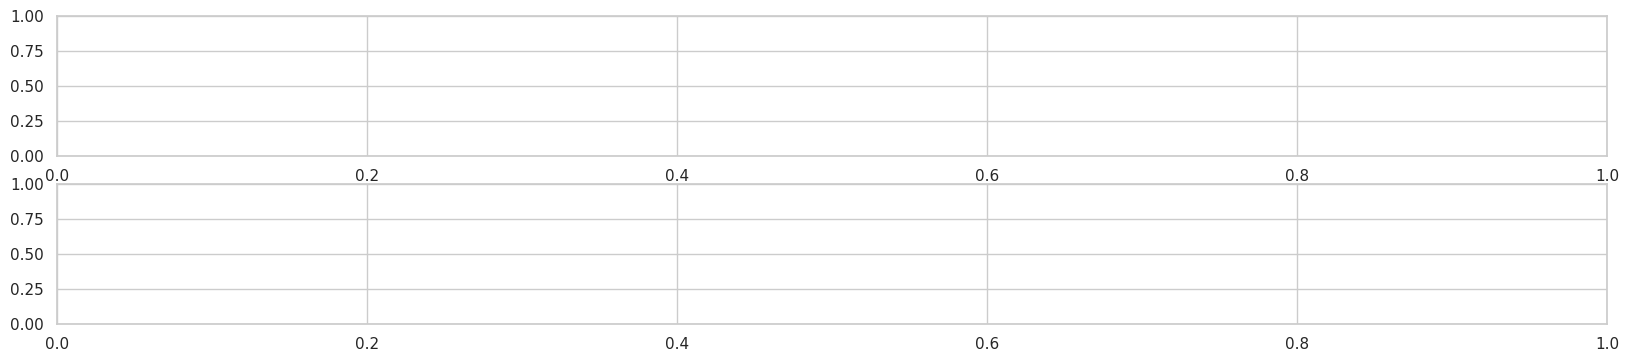

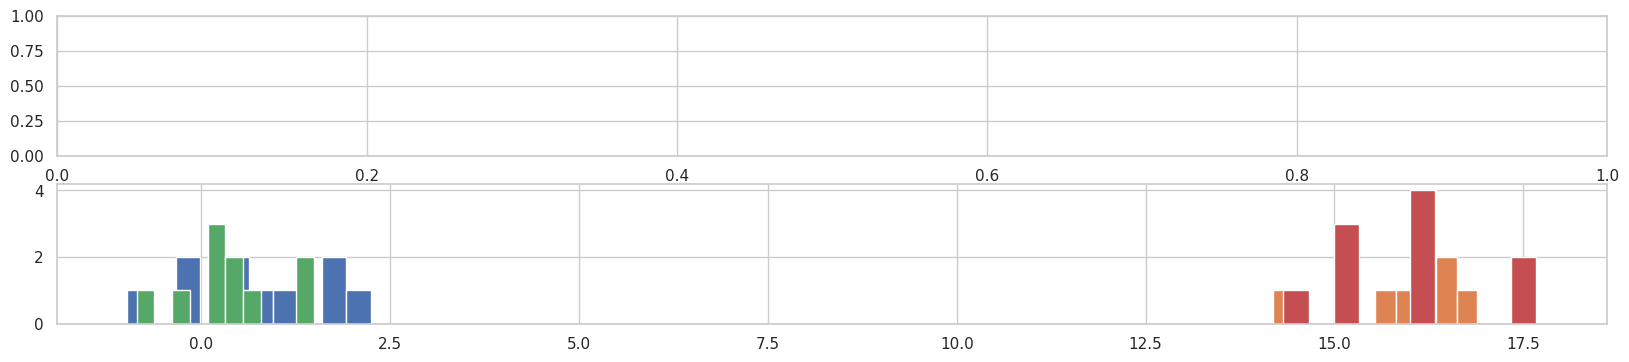

2024-10-25 15:24:35,836 - muvi.core.models - WARNING - No view names provided!
2024-10-25 15:24:35,837 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 15:24:35,839 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 15:24:35,840 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 15:24:35,841 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 15:24:35,841 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-25 15:24:35,842 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-25 15:24:35,843 - muvi.core.models - INFO - Normalizing observations.
2024-10-25 15:24:35,843 - muvi.core.models - INFO - Centering features of view `nonpbs`.
2024-10-25 15:24:35,845 - muvi.core.models - INFO - Setting global standard 

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 15:24:35,886 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:19, 33.29it/s, ELBO=30.9]

Relative improvement of -0.000925 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 15:24:45,990 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [48]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
genes = 100
cells = 10
sigma = 1 # sigma1=sigma2 for now
max_iter = 1000
K = 2 # num factors
factors = []
ws = []
taus = [16]
fig, ax = plt.subplots(2,figsize = (20,4))
fig1, ax1 = plt.subplots(2,figsize = (20,4))
for i,tau in enumerate(taus):
    x_control = np.random.normal(loc=0,scale=sigma,size=(genes,cells))
    x_treat = np.random.normal(loc=tau,scale=sigma,size=(genes,cells))
    
    plt.hist(x_control[0,:],label = 'control -0')
    plt.hist(x_treat[0,:],label = 'treatment -0')
    
    plt.hist(x_control[1,:],label = 'control -1')
    plt.hist(x_treat[1,:],label = 'treatment -1')
    plt.show()
    
    model = muvi.MuVI(
        observations={"pbs": x_control,
                      "nonpbs": x_treat},
        n_factors=K,
        device=device,
        prior_confidence='low',
    )
    model.fit(seed=0,n_epochs=max_iter)
    factor_scales = model._guide.get_factor_scale()
    factors.append(factor_scales / np.max(factor_scales, axis=1)[:, None])# delta of factor k in view m
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and cell j
    ws.append(np.concatenate(approx_ws, axis=1))
    
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(factors[i],annot=True,vmax= 1.0,ax=ax[i])
    
    ax1[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(ws[i],annot=True,vmax= 1.0,ax=ax1[i], center=0)
    # del model
    
# approx_x = model.get_factor_scores() # factors  
# muvi.pl.lined_heatmap(approx_x, center=0)


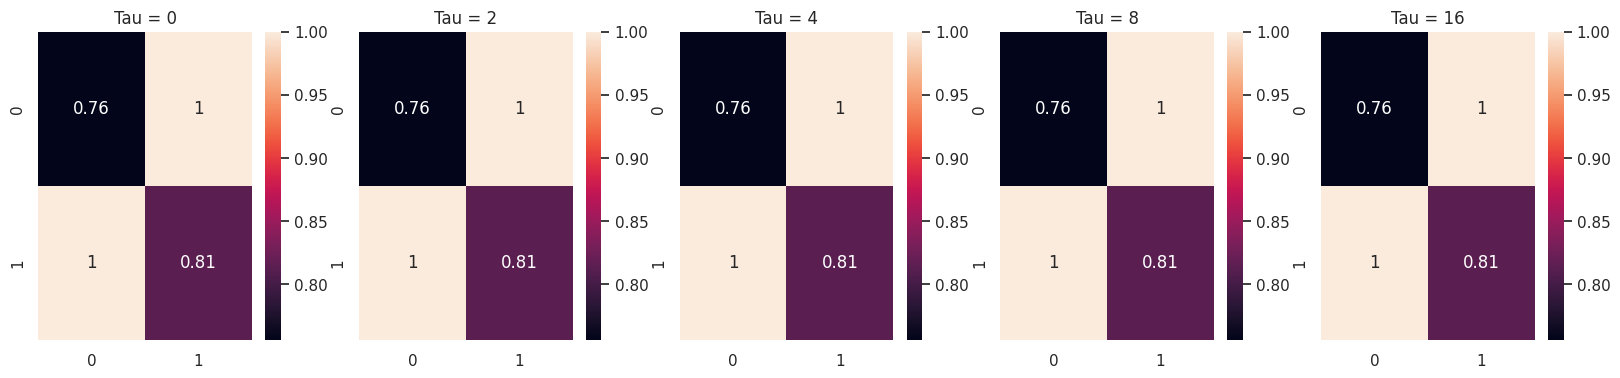

In [23]:
# plot delta by tau
fig, ax = plt.subplots(1,5,figsize = (20,4))
for i in range(len(factors)):
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(factors[i],annot=True,vmax= 1.0,ax=ax[i])

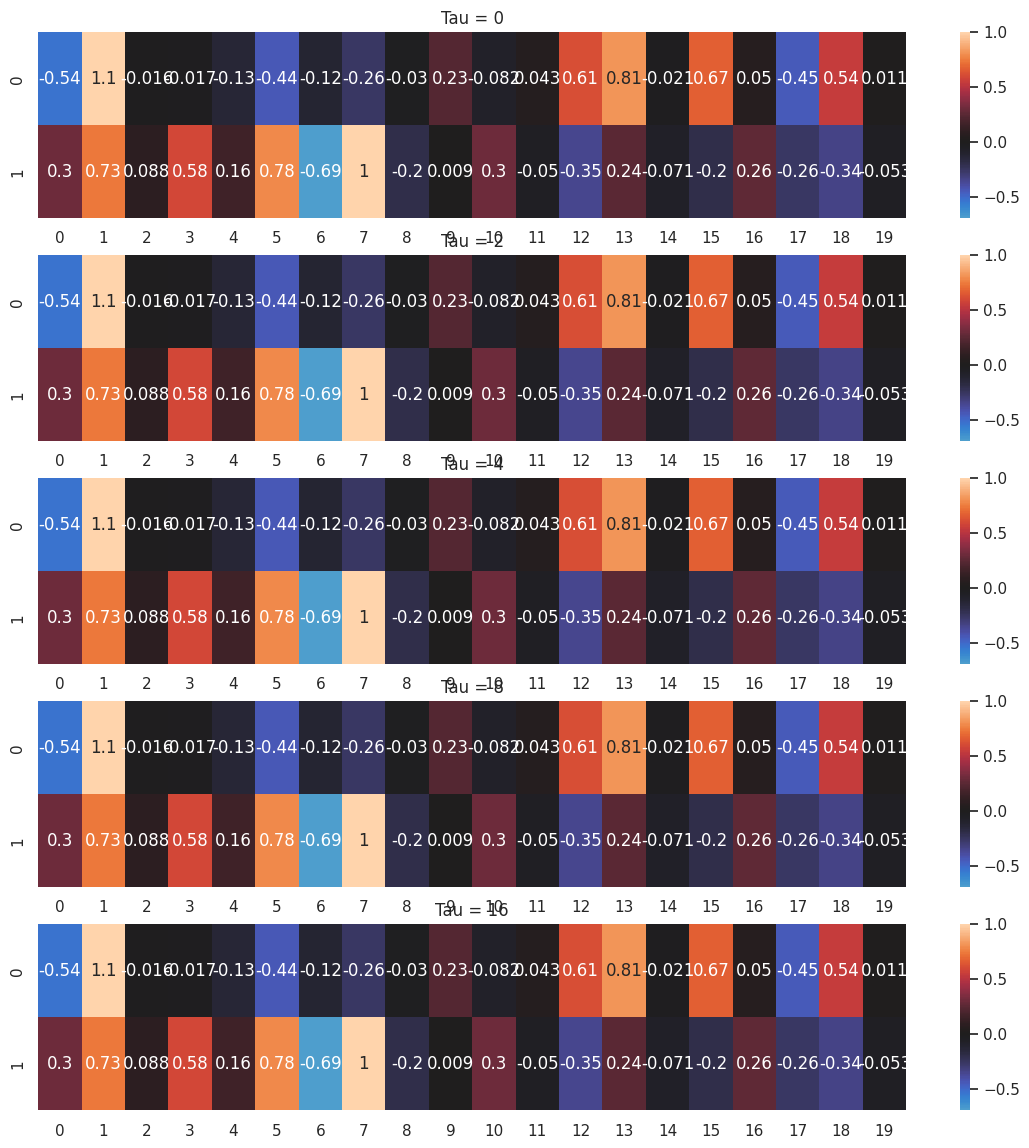

In [25]:
# plot W by tau
fig,ax = plt.subplots(5,figsize=(14,14))
for i in range(len(ws)):
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(ws[i],annot=True,vmax= 1.0,ax=ax[i], center=0)
plt.show()

# Fully connected with simulated data

In [30]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
genes = 100
cells = 10
sigma = 1 # sigma1=sigma2 for now
max_iter = 1000
K = 2 # num factors per view

factors = []
ws = []
for i,tau in enumerate([0,2,4,8,16]):
    model = muvi.MuVI(
        observations={"pbs": np.random.normal(loc=0,scale=sigma,size=(genes,cells)),
                      "nonpbs": np.random.normal(loc=tau,scale=sigma,size=(genes,cells))},
        # n_factors=K,
        device=device,
        prior_confidence='low',
        prior_masks = [np.ones((K,cells)),np.ones((K,cells))]
    )
    model.fit(seed=0,n_epochs=max_iter)
    factor_scales = model._guide.get_factor_scale()
    factors.append(factor_scales / np.max(factor_scales, axis=1)[:, None])# delta of factor k in view m
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and cell j
    ws.append(np.concatenate(approx_ws, axis=1))

2024-10-25 14:51:34,614 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:51:34,615 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:51:34,619 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:51:34,620 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:51:34,621 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:51:34,623 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:51:34,624 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:51:34,625 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-25 14:51:34,626 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-25 14:51:34,627 - muvi.core.models - INFO - Normalizing observations.
2024-10-25 14:51:34

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:51:34,678 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 32.97it/s, ELBO=30.9]

Relative improvement of -0.000925 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:51:44,878 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:51:44,880 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:51:44,881 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:51:44,882 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:51:44,883 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:51:44,884 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:51:44,885 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:51:44,886 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:51:44,887 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:51:44,926 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 33.13it/s, ELBO=30.9]

Relative improvement of -0.000925 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:51:55,079 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:51:55,082 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:51:55,083 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:51:55,085 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:51:55,085 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:51:55,086 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:51:55,087 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:51:55,088 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:51:55,090 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:51:55,129 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 33.03it/s, ELBO=30.9]

Relative improvement of -0.0009249 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:52:05,313 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:52:05,316 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:52:05,316 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:52:05,318 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:52:05,319 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:52:05,320 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:52:05,321 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:52:05,321 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:52:05,322 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:52:05,360 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 32.01it/s, ELBO=30.9]

Relative improvement of -0.000925 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:52:15,872 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:52:15,875 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:52:15,875 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:52:15,877 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:52:15,877 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:52:15,878 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:52:15,879 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:52:15,880 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:52:15,882 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:52:15,919 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 32.85it/s, ELBO=30.9]

Relative improvement of -0.000925 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:52:26,159 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


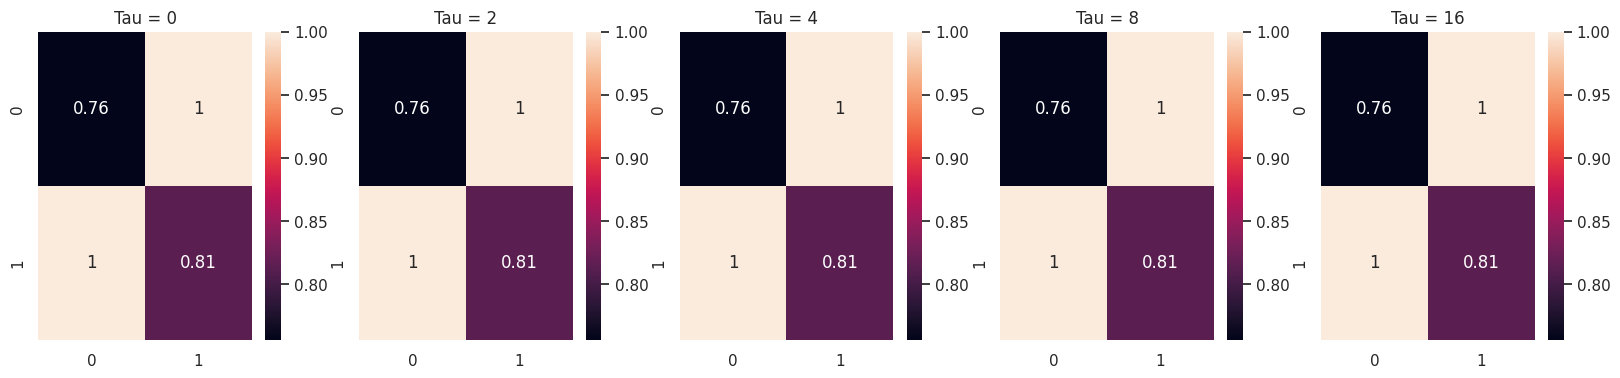

In [31]:
# plot delta by tau
fig, ax = plt.subplots(1,5,figsize = (20,4))
for i in range(len(factors)):
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(factors[i],annot=True,vmax= 1.0,ax=ax[i])

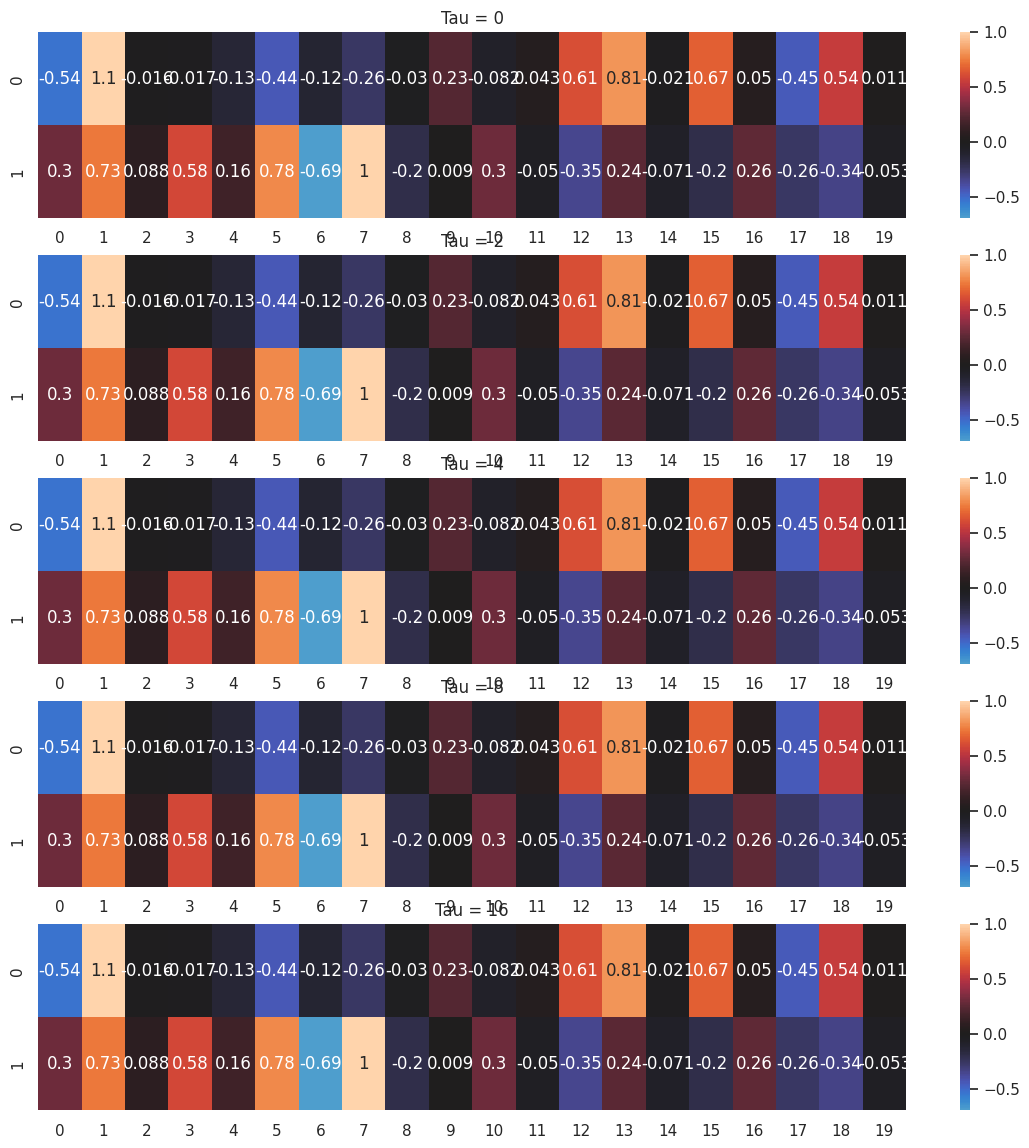

In [32]:
# plot W by tau
fig,ax = plt.subplots(5,figsize=(14,14))
for i in range(len(ws)):
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(ws[i],annot=True,vmax= 1.0,ax=ax[i], center=0)
plt.show()

# Masked private factors only in simulated data

In [37]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
genes = 100
cells = 10
sigma = 1 # sigma1=sigma2 for now
max_iter = 1000
K = 2 # num factors per view

factors = []
ws = []
for i,tau in enumerate([0,2,4,8,16]):
    model = muvi.MuVI(
        observations={"pbs": np.random.normal(loc=0,scale=sigma,size=(genes,cells)),
                      "nonpbs": np.random.normal(loc=tau,scale=sigma,size=(genes,cells))},
        # n_factors=K,
        device=device,
        prior_confidence='low',
        prior_masks = generate_mask(K=K,
              c1=cells, # num_samples PBS
              c2=cells) # num_samples Non PBS
    )
    model.fit(seed=0,n_epochs=max_iter)
    factor_scales = model._guide.get_factor_scale()
    factors.append(factor_scales / np.max(factor_scales, axis=1)[:, None])# delta of factor k in view m
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and cell j
    ws.append(np.concatenate(approx_ws, axis=1))

2024-10-25 14:56:10,881 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:56:10,883 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:56:10,887 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:56:10,888 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:56:10,889 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:56:10,891 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:10,892 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:10,893 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-25 14:56:10,894 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-25 14:56:10,894 - muvi.core.models - INFO - Normalizing observations.
2024-10-25 14:56:10

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:56:10,995 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 32.96it/s, ELBO=31.9]

Relative improvement of -0.0007543 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:56:21,184 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:56:21,187 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:56:21,188 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:56:21,190 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:56:21,190 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:56:21,191 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:56:21,193 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:21,193 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:21,194 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:56:21,236 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:20, 32.94it/s, ELBO=31.9]

Relative improvement of -0.0007543 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:56:31,448 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:56:31,451 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:56:31,451 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:56:31,453 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:56:31,454 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:56:31,454 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:56:31,456 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:31,457 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:31,457 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:56:31,497 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:19, 33.17it/s, ELBO=31.9]

Relative improvement of -0.0007543 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:56:41,639 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:56:41,642 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:56:41,642 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:56:41,644 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:56:41,645 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:56:41,645 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:56:41,647 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:41,647 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:41,648 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:56:41,689 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:19, 33.22it/s, ELBO=31.9]

Relative improvement of -0.0007543 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:56:51,815 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.
2024-10-25 14:56:51,818 - muvi.core.models - WARNING - No view names provided!
2024-10-25 14:56:51,819 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-25 14:56:51,820 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-25 14:56:51,821 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-25 14:56:51,821 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-25 14:56:51,823 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:51,824 - muvi.core.models - INFO - np.ndarray detected.
2024-10-25 14:56:51,825 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-10-25 14:56:51,863 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 337/1000 [00:10<00:19, 33.27it/s, ELBO=31.9]

Relative improvement of -0.0007543 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-25 14:57:01,976 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


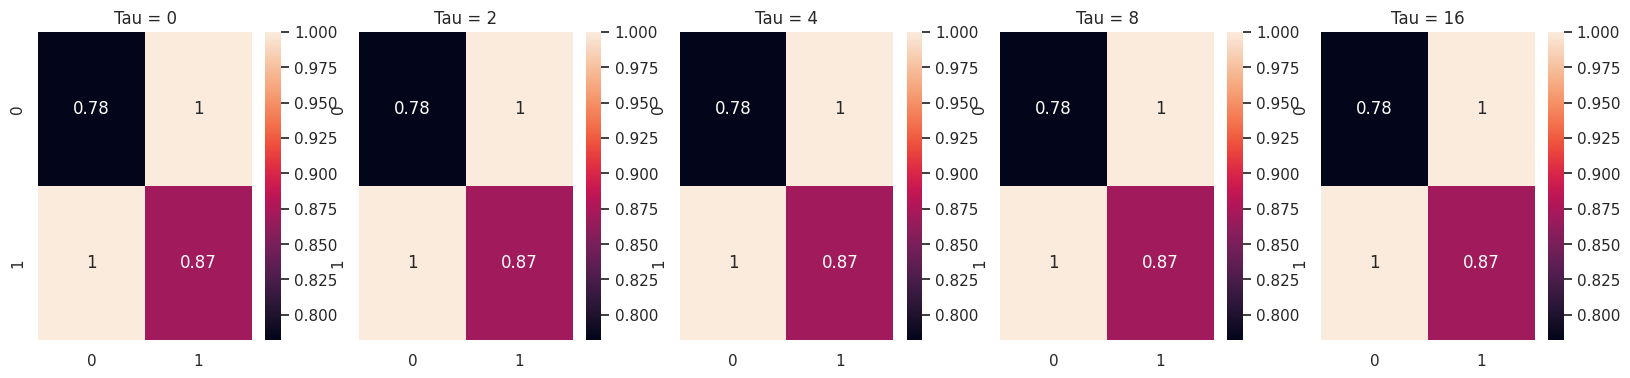

In [38]:
# plot delta by tau
fig, ax = plt.subplots(1,5,figsize = (20,4))
for i in range(len(factors)):
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(factors[i],annot=True,vmax= 1.0,ax=ax[i])

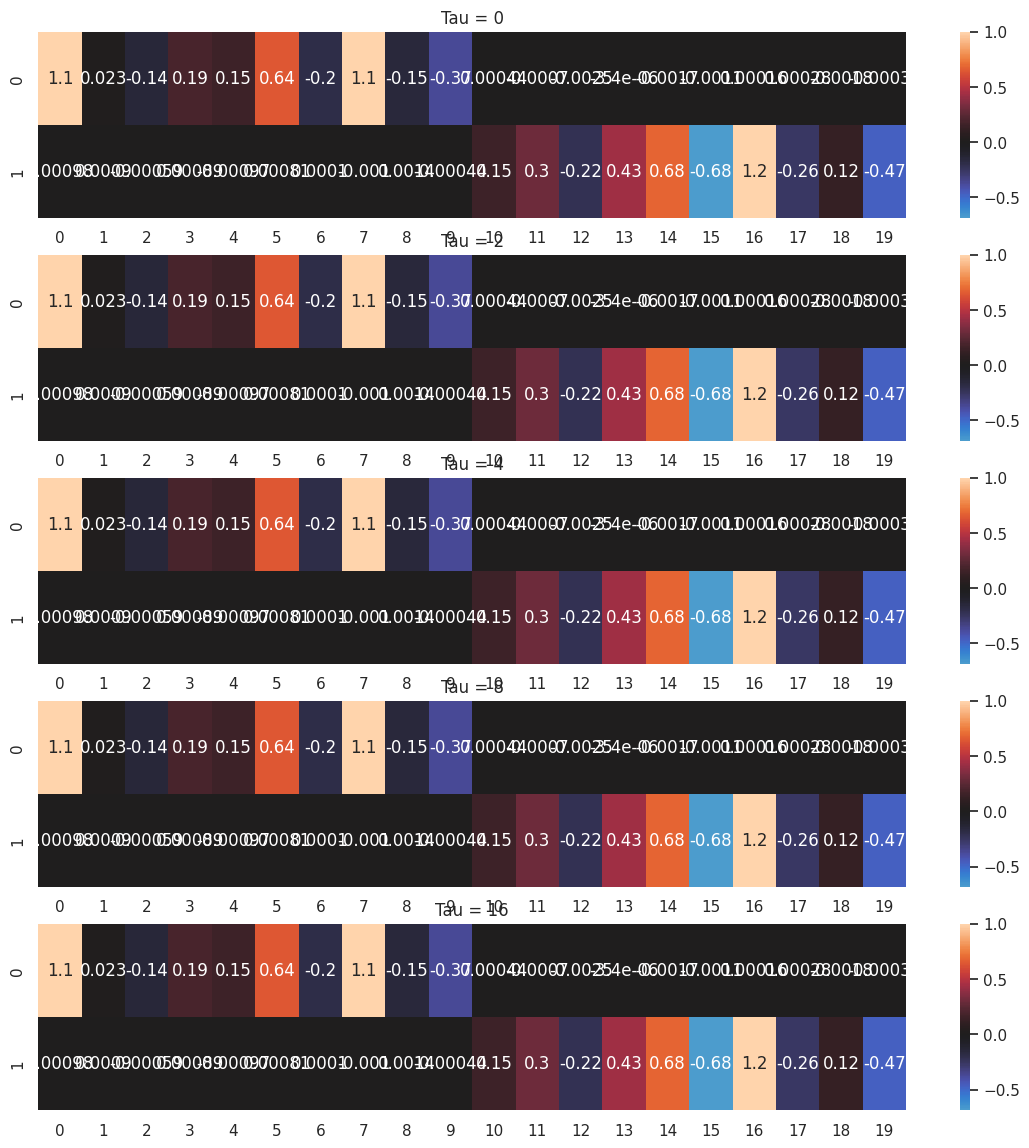

In [39]:
# plot W by tau
fig,ax = plt.subplots(5,figsize=(14,14))
for i in range(len(ws)):
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(ws[i],annot=True,vmax= 1.0,ax=ax[i], center=0)
plt.show()

# REAL DATA

# Method 1: unsupervised MF

In [6]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
model = muvi.MuVI(
    observations={"pbs": np.normal(), # TODO : remove computing for first 100
                  "nonpbs": adata[adata.obs['sample']!='PBS'].X[:100].T.todense()},
    n_factors=10,
    device=device,
    prior_confidence='low',
)

2024-10-11 14:57:28,152 - muvi.core.models - WARNING - Running MuVI on a single view.
2024-10-11 14:57:28,153 - muvi.core.models - INFO - pd.DataFrame detected.
2024-10-11 14:57:28,154 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2024-10-11 14:57:28,155 - muvi.core.models - INFO - pd.DataFrame detected.
2024-10-11 14:57:28,177 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal'}`.
2024-10-11 14:57:28,177 - muvi.core.models - INFO - NMF set to `{'rna': False}`.
2024-10-11 14:57:28,178 - muvi.core.models - INFO - Normalizing observations.
2024-10-11 14:57:28,179 - muvi.core.models - INFO - Centering features of view `rna`.
2024-10-11 14:57:28,280 - muvi.core.models - INFO - Setting global standard deviation to 1.0 (from 11.062).
2024-10-11 14:57:28,285 - muvi.core.models - INFO - Running all computations on `cuda:0`.


|================================|
|       MuVI version 0.1.4       |
|================================|
| Parameter        | Value       |
|------------------|-------------|
| n_views          | 1           |
| n_samples        | 300         |
| n_features       | rna: 31053  |
| n_factors        | 10          |
| prior_confidence | 0.99        |
| n_covariates     | 0           |
| likelihoods      | rna: normal |
| nmf              | rna: False  |
| reg_hs           | True        |
| device           | cuda:0      |
|================================|

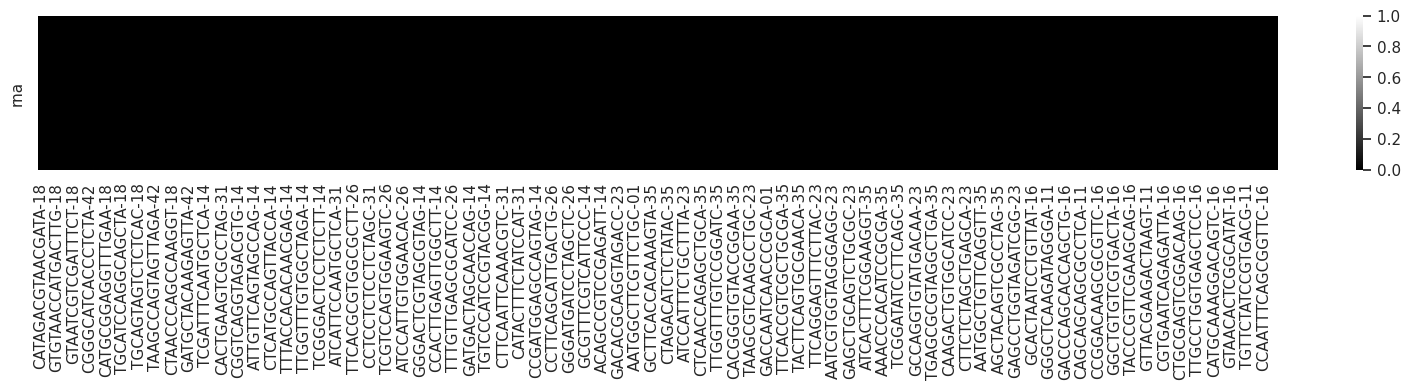

<Axes: >

In [7]:
muvi.pl.missingness_overview(model) # no variables are missing

In [8]:
model.fit(seed=0,n_epochs=10)

2024-10-11 14:57:29,568 - muvi.core.models - INFO - Using 3 particles in parallel.
2024-10-11 14:57:29,568 - muvi.core.models - INFO - Preparing model and guide...
2024-10-11 14:57:29,570 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2024-10-11 14:57:29,642 - muvi.core.models - INFO - Preparing optimizer...
2024-10-11 14:57:29,643 - muvi.core.models - INFO - Decaying learning rate over 10 iterations.
2024-10-11 14:57:29,643 - muvi.core.models - INFO - Preparing SVI...
2024-10-11 14:57:29,644 - muvi.core.models - INFO - Preparing training data...
2024-10-11 14:57:29,739 - muvi.core.models - INFO - Using complete dataset.
2024-10-11 14:57:29,754 - muvi.core.models - INFO - Setting training seed to `0`.
2024-10-11 14:57:29,757 - muvi.core.models - INFO - Cleaning parameter store.
2024-10-11 14:57:29,758 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

2024-10-11 14:57:31,025 - root - INFO - Guessed max_plate_nesting = 3


100%|██████████| 10/10 [00:02<00:00,  4.82it/s, ELBO=4.87e+4]

2024-10-11 14:57:31,834 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<Axes: >

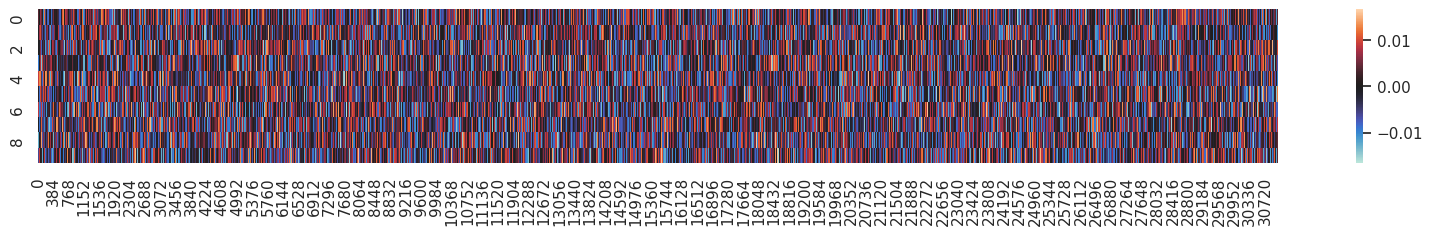

In [9]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)
muvi.pl.lined_heatmap(approx_w, center=0)

# Methods 2: PBS vs Non-PBS

In [15]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
    print(device)
except Exception as e:
    print(e)

cuda:0


In [16]:
# load out data. FIRST run data_transformation_r_to_python nb
# Then run this chunk
path = '../spectra_experiments/'
# Load the main data matrix
data = mmread(path+"B_cell_counts.mtx").transpose().tocsr()  # Convert to CSR format which is more efficient for row slicing

# Load metadata
meta_data = pd.read_csv(path+"meta_data.csv", index_col=0)

# Create an AnnData object
adata = ad.AnnData(X=data, obs=meta_data)
print(adata)

AnnData object with n_obs × n_vars = 8086 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep'


In [54]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
model = muvi.MuVI(
    observations={"pbs": adata[adata.obs['sample']=='PBS'].X[:100].T.todense(), # TODO : remove computing for first 100
                  "nonpbs": adata[adata.obs['sample']!='PBS'].X[:100].T.todense()},
    n_factors=10,
    device=device,
    prior_confidence='low',
)

2024-10-10 23:24:21,104 - muvi.core.models - WARNING - No view names provided!
2024-10-10 23:24:21,105 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-10 23:24:21,206 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-10 23:24:21,219 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-10 23:24:21,220 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-10 23:24:21,240 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-10 23:24:21,240 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-10 23:24:21,241 - muvi.core.models - INFO - Normalizing observations.
2024-10-10 23:24:21,242 - muvi.core.models - INFO - Centering features of view `nonpbs`.
2024-10-10 23:24:21,280 - muvi.core.models - INFO - Setting global standard 

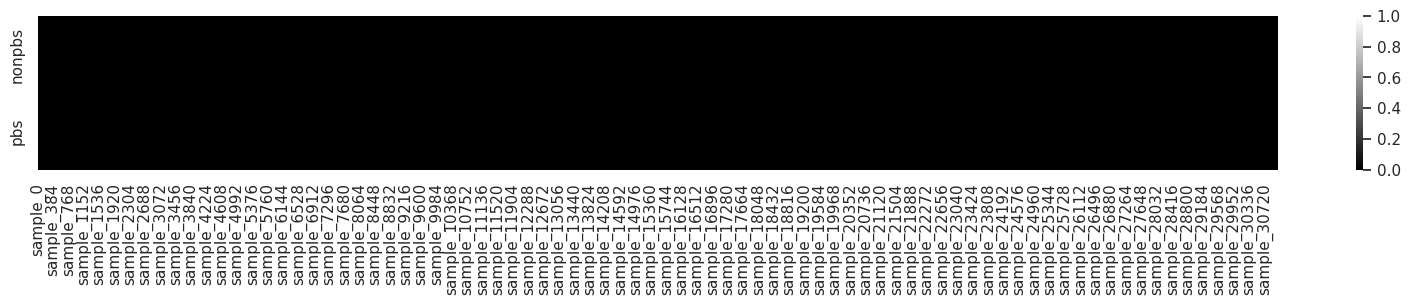

<Axes: >

In [56]:
muvi.pl.missingness_overview(model) # no variables are missing

In [58]:
model.fit(seed=0,n_epochs=10)

2024-10-10 23:25:56,174 - muvi.core.models - INFO - Preparing model and guide...
2024-10-10 23:25:56,175 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2024-10-10 23:25:56,192 - muvi.core.models - INFO - Preparing optimizer...
2024-10-10 23:25:56,193 - muvi.core.models - INFO - Decaying learning rate over 10 iterations.
2024-10-10 23:25:56,193 - muvi.core.models - INFO - Preparing SVI...
2024-10-10 23:25:56,194 - muvi.core.models - INFO - Preparing training data...
2024-10-10 23:25:56,239 - muvi.core.models - INFO - Using complete dataset.
2024-10-10 23:25:56,250 - muvi.core.models - INFO - Setting training seed to `0`.
2024-10-10 23:25:56,282 - muvi.core.models - INFO - Cleaning parameter store.
2024-10-10 23:25:56,284 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

2024-10-10 23:25:56,321 - root - INFO - Guessed max_plate_nesting = 2


100%|██████████| 10/10 [00:00<00:00, 15.77it/s, ELBO=296]

2024-10-10 23:25:56,922 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<Axes: >

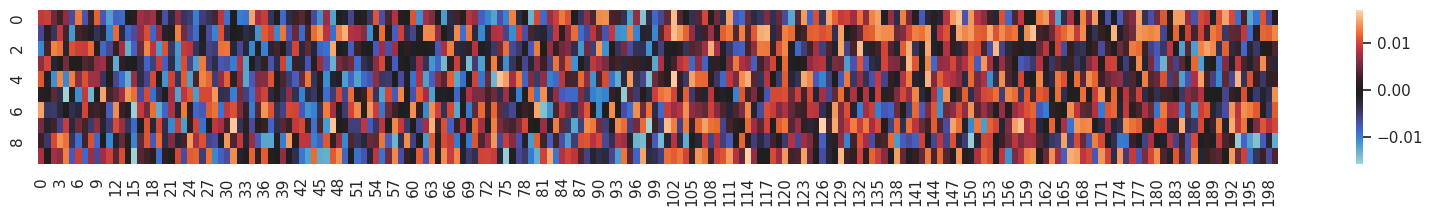

In [59]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)
muvi.pl.lined_heatmap(approx_w, center=0)

Let's produce a mask as follows num_factors x num_samples:
1. first L rows / factors will be common to both; 
2. next L will be private to PBS
3. next L will be private to Non-PBS

We'll have no partially shared factors

In [18]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
model = muvi.MuVI(
    observations={"pbs": adata[adata.obs['sample']=='PBS'].X[:100].T.todense(), # TODO : remove computing for first 100
                  "nonpbs": adata[adata.obs['sample']!='PBS'].X[:100].T.todense()},
    prior_masks=generate_mask(K=30, # divisible by 3
              c1=100, # num_samples PBS
              c2=100), # num_samples Non PBS,
    device=device,
    prior_confidence='high',
)

2024-10-11 14:58:27,865 - muvi.core.models - WARNING - No view names provided!
2024-10-11 14:58:27,866 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-11 14:58:27,967 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-11 14:58:27,980 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-11 14:58:27,982 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-11 14:58:28,003 - muvi.core.models - INFO - np.ndarray detected.
2024-10-11 14:58:28,004 - muvi.core.models - INFO - np.ndarray detected.
2024-10-11 14:58:28,005 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-11 14:58:28,006 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-11 14:58:28,007 - muvi.core.models - INFO - Normalizing observations.
2024-10-11 14:58:28

In [19]:
model.fit(seed=0,n_epochs=10000)

2024-10-11 14:58:29,083 - muvi.core.models - INFO - Preparing model and guide...
2024-10-11 14:58:29,104 - muvi.core.models - INFO - Preparing optimizer...
2024-10-11 14:58:29,105 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-10-11 14:58:29,106 - muvi.core.models - INFO - Preparing SVI...
2024-10-11 14:58:29,108 - muvi.core.models - INFO - Preparing training data...
2024-10-11 14:58:29,156 - muvi.core.models - INFO - Using complete dataset.
2024-10-11 14:58:29,168 - muvi.core.models - INFO - Setting training seed to `0`.
2024-10-11 14:58:29,175 - muvi.core.models - INFO - Cleaning parameter store.
2024-10-11 14:58:29,175 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-11 14:58:29,210 - root - INFO - Guessed max_plate_nesting = 2


 16%|█▌        | 1596/10000 [00:59<05:15, 26.66it/s, ELBO=-30]   

Relative improvement of -0.006823 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-11 14:59:29,038 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<Axes: >

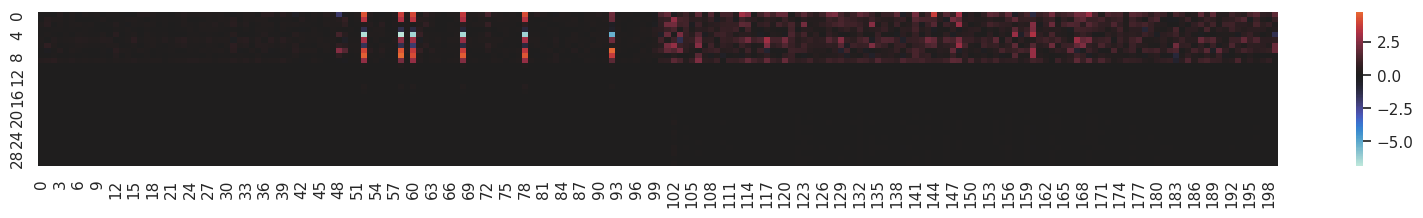

In [20]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)
muvi.pl.lined_heatmap(approx_w, center=0)

In [1]:
model

NameError: name 'model' is not defined

In [21]:
# overall RMSE
root_mean_squared_error(
        np.concatenate(list(model.get_observations(as_df=False).values()),axis=1),
    np.concatenate([model.get_reconstructed()[vn] for vn in model.view_names], 1),
)


0.29309342887212336

In [22]:
from matplotlib import pyplot as plt

(array([ 1.,  1.,  1.,  4.,  6.,  9.,  9., 26., 26., 17.]),
 array([-0.24411904, -0.22412851, -0.20413799, -0.18414746, -0.16415693,
        -0.14416641, -0.12417588, -0.10418535, -0.08419483, -0.0642043 ,
        -0.04421377]),
 <BarContainer object of 10 artists>)

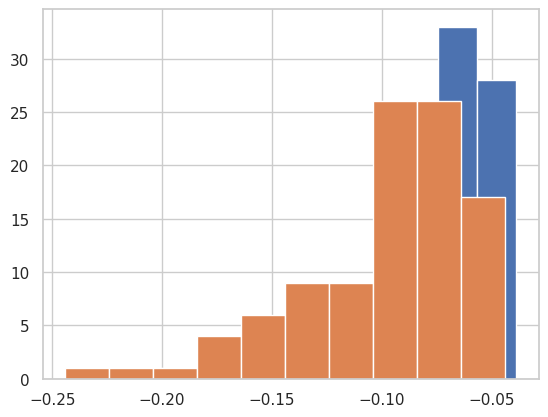

In [25]:
plt.hist(model.get_observations(as_df=False)['pbs'][1])
plt.hist(model.get_reconstructed()['pbs'][1])